In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wikitext-2-v1/wikitext-2/wiki.train.tokens
/kaggle/input/wikitext-2-v1/wikitext-2/wiki.valid.tokens
/kaggle/input/wikitext-2-v1/wikitext-2/wiki.test.tokens
/kaggle/input/glove-100d/wiki_giga_2024_100_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05.050_combined.txt
/kaggle/input/bert-test/config.json
/kaggle/input/bert-test/tokenizer.json
/kaggle/input/bert-test/tokenizer_config.json
/kaggle/input/bert-test/pytorch_model.bin
/kaggle/input/bert-test/vocab.txt


In [22]:
# =====================
# 参数配置
# =====================
import torch

PARAMS = {
    "MODEL_TYPE": "decoder-only",   # "encoder-decoder" 或 "decoder-only"
    "EMBED_DIM": 128,
    "HIDDEN_DIM": 256,
    "NUM_LAYERS": 2,
    "NUM_HEADS": 4,
    "DROPOUT": 0.1,
    "LR": 1e-3,
    "BATCH_SIZE": 32,
    "EPOCHS": 5,
    "MAX_SEQ_LEN": 64
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 日志保存文件
RESULTS_FILE = "/kaggle/working/results.csv"

In [23]:
# =====================
# 数据加载 & 预处理
# =====================
import os
from torch.utils.data import Dataset, DataLoader

DATA_DIR = "/kaggle/input/wikitext-2-v1/wikitext-2"  
TRAIN_FILE = os.path.join(DATA_DIR, "wiki.train.tokens")
VALID_FILE = os.path.join(DATA_DIR, "wiki.valid.tokens")
TEST_FILE  = os.path.join(DATA_DIR, "wiki.test.tokens")

def load_file(path):
    with open(path, encoding="utf-8") as f:
        return [line.strip() for line in f if line.strip()]

train_texts = load_file(TRAIN_FILE)
valid_texts = load_file(VALID_FILE)
test_texts  = load_file(TEST_FILE)

# 简单分词 & 词表构建
def tokenize(texts):
    return [line.split() for line in texts]

train_tokens = tokenize(train_texts)
valid_tokens = tokenize(valid_texts)
test_tokens  = tokenize(test_texts)

vocab = {"<pad>":0, "<unk>":1}
for line in train_tokens:
    for tok in line:
        if tok not in vocab:
            vocab[tok] = len(vocab)
            
PAD_IDX = vocab["<pad>"]
UNK_IDX = vocab["<unk>"]
VOCAB_SIZE = len(vocab)

def encode(tokens, vocab, max_len):
    ids = [vocab.get(t, UNK_IDX) for t in tokens]
    ids = ids[:max_len]
    ids += [PAD_IDX] * (max_len - len(ids))
    return ids

class TextDataset(Dataset):
    def __init__(self, data, vocab, max_len):
        self.data = data
        self.vocab = vocab
        self.max_len = max_len
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x = encode(self.data[idx][:-1], self.vocab, self.max_len)
        y = encode(self.data[idx][1:], self.vocab, self.max_len)
        return torch.tensor(x), torch.tensor(y)

train_dataset = TextDataset(train_tokens, vocab, PARAMS["MAX_SEQ_LEN"])
valid_dataset = TextDataset(valid_tokens, vocab, PARAMS["MAX_SEQ_LEN"])
test_dataset  = TextDataset(test_tokens, vocab, PARAMS["MAX_SEQ_LEN"])

train_loader = DataLoader(train_dataset, batch_size=PARAMS["BATCH_SIZE"], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=PARAMS["BATCH_SIZE"])
test_loader  = DataLoader(test_dataset,  batch_size=PARAMS["BATCH_SIZE"])


In [24]:
# =====================
# 模型定义
# =====================
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, model_type, vocab_size, embed_dim, hidden_dim, num_layers, num_heads, dropout, max_len):
        super().__init__()
        self.model_type = model_type
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.pos_encoding = nn.Embedding(max_len, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, src, tgt=None):
        seq_len = src.size(1)
        pos = torch.arange(0, seq_len, device=src.device).unsqueeze(0)
        src_embed = self.embedding(src) + self.pos_encoding(pos)

        if self.model_type == "encoder-decoder":
            memory = self.encoder(src_embed.transpose(0,1))  # (S,N,E)
            if tgt is not None:
                tgt_seq_len = tgt.size(1)
                tgt_pos = torch.arange(0, tgt_seq_len, device=tgt.device).unsqueeze(0)
                tgt_embed = self.embedding(tgt) + self.pos_encoding(tgt_pos)
                output = self.decoder(tgt_embed.transpose(0,1), memory)
            else:
                output = memory
        else:  # decoder-only
            output = self.encoder(src_embed.transpose(0,1))

        logits = self.fc(output.transpose(0,1))
        return logits


In [25]:
# =====================
# 训练 & 验证 & 测试
# =====================
import torch.optim as optim
from torch.nn.functional import cross_entropy

def train_model(model, train_loader, valid_loader, test_loader, params):
    optimizer = optim.Adam(model.parameters(), lr=params["LR"])
    best_valid_loss = float("inf")

    results = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}

    for epoch in range(params["EPOCHS"]):
        # ---------- Train ----------
        model.train()
        total_loss, total_correct, total_count = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            output = model(x, x if params["MODEL_TYPE"]=="encoder-decoder" else None)
            loss = cross_entropy(output.view(-1, VOCAB_SIZE), y.view(-1), ignore_index=PAD_IDX)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += (output.argmax(-1) == y).sum().item()
            total_count += y.numel()
        train_loss = total_loss / len(train_loader)
        train_acc  = total_correct / total_count

        # ---------- Valid ----------
        model.eval()
        total_loss, total_correct, total_count = 0, 0, 0
        with torch.no_grad():
            for x, y in valid_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                output = model(x, x if params["MODEL_TYPE"]=="encoder-decoder" else None)
                loss = cross_entropy(output.view(-1, VOCAB_SIZE), y.view(-1), ignore_index=PAD_IDX)
                total_loss += loss.item()
                total_correct += (output.argmax(-1) == y).sum().item()
                total_count += y.numel()
        valid_loss = total_loss / len(valid_loader)
        valid_acc  = total_correct / total_count

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, Valid Loss={valid_loss:.4f}, Acc={valid_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)

    # ---------- Test ----------
    model.eval()
    total_loss, total_correct, total_count = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            output = model(x, x if params["MODEL_TYPE"]=="encoder-decoder" else None)
            loss = cross_entropy(output.view(-1, VOCAB_SIZE), y.view(-1), ignore_index=PAD_IDX)
            total_loss += loss.item()
            total_correct += (output.argmax(-1) == y).sum().item()
            total_count += y.numel()
    test_loss = total_loss / len(test_loader)
    test_acc  = total_correct / total_count

    print(f"Test: Loss={test_loss:.4f}, Acc={test_acc:.4f}")
    return results, (test_loss, test_acc)


In [26]:
import matplotlib.pyplot as plt

def plot_results(results):
    epochs = range(1, len(results["train_loss"]) + 1)

    # Loss
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, results["train_loss"], label="Train Loss")
    plt.plot(epochs, results["valid_loss"], label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, results["train_acc"], label="Train Acc")
    plt.plot(epochs, results["valid_acc"], label="Valid Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()




/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1: Train Loss=3.9879, Acc=0.3384, Valid Loss=1.0392, Acc=0.5759
Epoch 2: Train Loss=0.6983, Acc=0.5911, Valid Loss=0.3252, Acc=0.6310
Epoch 3: Train Loss=0.2517, Acc=0.6236, Valid Loss=0.1948, Acc=0.6412
Epoch 4: Train Loss=0.1448, Acc=0.6309, Valid Loss=0.1624, Acc=0.6448
Epoch 5: Train Loss=0.1131, Acc=0.6336, Valid Loss=0.1564, Acc=0.6449
Test: Loss=0.1736, Acc=0.6230


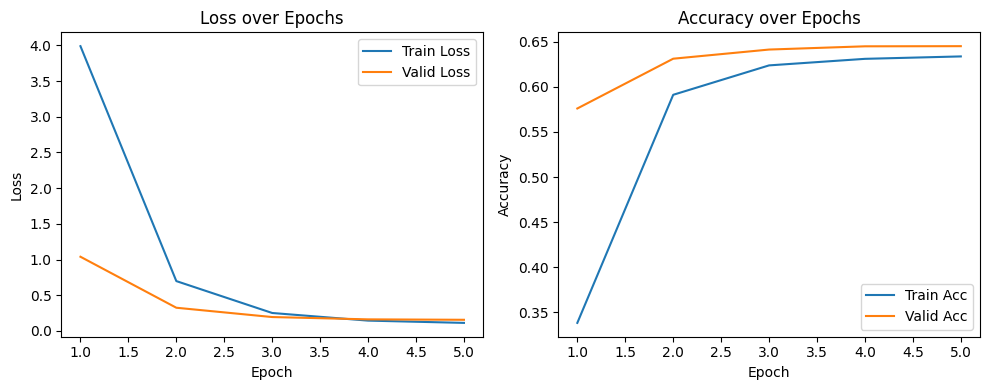

In [27]:
# =====================
# 主程序
# =====================
model = TransformerModel(
    model_type=PARAMS["MODEL_TYPE"],
    vocab_size=VOCAB_SIZE,
    embed_dim=PARAMS["EMBED_DIM"],
    hidden_dim=PARAMS["HIDDEN_DIM"],
    num_layers=PARAMS["NUM_LAYERS"],
    num_heads=PARAMS["NUM_HEADS"],
    dropout=PARAMS["DROPOUT"],
    max_len=PARAMS["MAX_SEQ_LEN"]
).to(DEVICE)

results, test_result = train_model(model, train_loader, valid_loader, test_loader, PARAMS)
plot_results(results)